In [72]:
import numpy as np
from igraph import *
from time import time

from collections import defaultdict
import itertools

from operator import itemgetter

import matplotlib.pyplot as plt

DATA_DIR = '/Users/sahil/scikit_learn_data/Flickr_sampled_edges/'

In [6]:
community_memberships = np.loadtxt(DATA_DIR+'community_membership_2K.csv', delimiter=',', dtype='int')
edges = np.loadtxt(DATA_DIR+'edges_sampled_map_2K.csv', delimiter=',', dtype='int')

In [7]:
edges.shape, community_memberships.shape, np.max(edges), np.max(community_memberships)

((2098, 2), (318, 2), 317, 317)

In [69]:

class Community: 
    def __init__(self, edges):
        self._edges = edges
        self._vertices = np.unique(edges)
        self.graph = self._make_graph()
        
    def __str__(self):
        print(self.graph)
        return ''
    
    def _make_graph(self):
        g = Graph()
        any(g.add_vertex(v) for v in self._vertices)
        g.add_edges(self._edges)
        return g
    
    def find_all_pairs_shortest_paths(self):
        _all_pairs_shortest_paths = defaultdict(list)
        for u, v in itertools.combinations(self._vertices, 2):
            _all_pairs_shortest_paths[(u, v)] = self.graph.get_all_shortest_paths(u, v)

        self._all_pairs_shortest_paths = _all_pairs_shortest_paths
        return self._all_pairs_shortest_paths

    def _betweeness(self, edge):
        u, v = edge
        betweenness = 0
        for pair, shortest_paths in self._all_pairs_shortest_paths.items():
            if len(shortest_paths) == 0:
                continue
            paths_through_edge = 0
            for path in shortest_paths:
                for _e in [(path[i-1], path[i]) for i in range(1, len(path))]:
                    if (_e[0] == edge[0] and _e[1] == edge[1]) or (_e[1] == edge[0] and _e[0] == edge[1]):
                        paths_through_edge += 1
            betweenness += paths_through_edge/len(shortest_paths)
        return betweenness

    def find_edge_betweenness(self, recompute_apsp=False):
        if recompute_apsp:
            self._all_pairs_shortest_paths = self.find_all_pairs_shortest_paths()
        edge_betweennes = defaultdict(lambda: 0)
        
        for pair, shortest_paths in self._all_pairs_shortest_paths.items():
            for path in shortest_paths:
                for edge in [(path[i-1], path[i]) for i in range(1, len(path))]:
                    edge = tuple(sorted(edge))
                    edge_betweennes[edge] += (1 / len(shortest_paths))
        self.edge_betweenness = edge_betweennes
        return self.edge_betweenness
    
    def delete_top_edges(self, k=5):
        ''' Deletes top k edges based on betweenness scores '''
        edges_to_delete = sorted(self.edge_betweenness, key=itemgetter(1), reverse=True)[:k]
        self.graph.delete_edges(edges_to_delete)
        
    def modularity(self, memberships=None):
        modularity = 0
        n_edges = len(self.graph.es)
        n_vertices = len(self.graph.vs)
        memberships = self.graph.components().membership if memberships is None else memberships
        for u in range(n_vertices):
            for v in range(n_vertices):
                if memberships[u] == memberships[v]:
                    # if there exists an edge from u->v
                    if self.graph.get_eid(u, v, directed=False, error=False) != -1:
                        modularity += 1
                    modularity -= (self.graph.degree(u) * self.graph.degree(v)) / (2 * n_edges)
        modularity *= (1 / (2 * n_edges))
        modularity = modularity if modularity >= 0 else 0
        
        self._mods.append(modularity)
        self._communities.append(len(np.unique(memberships)))
        
        return modularity
#         return self.graph.modularity(self.graph.components().membership)
    
    def reduce_modularity(self, community_count=10, k=5):
        i = 0
        self._mods = []
        self._communities = []
        while True:
            i += 1
            t = time()
            self.find_edge_betweenness(True)
            g.delete_top_edges(k)
            g.modularity()
            print(i, round(self._mods[-1], 3), self._communities[-1], round(time()-t, 3))
            
            if self._communities[-1] >= community_count:
                break

In [70]:
g = Community(edges)

# __apsp = g.find_all_pairs_shortest_paths()
# __e_btwn = g.find_edge_betweenness()

g._all_pairs_shortest_paths = __apsp
g.edge_betweenness = __e_btwn

In [78]:
# print(g.modularity())
# g.delete_top_edges()
# print(g.modularity())

g.reduce_modularity(community_count=300, k=5)

1 0.042 203 9.12
2 0.042 203 10.198
3 0.042 205 9.309
4 0.043 205 8.783
5 0.043 205 8.315
6 0.043 206 8.336
7 0.043 206 8.579
8 0.043 207 8.123
9 0.044 207 8.064
10 0.044 207 8.037
11 0.044 207 8.041
12 0.044 208 8.04
13 0.045 208 8.161
14 0.045 208 7.866
15 0.045 208 7.908
16 0.045 209 7.824
17 0.046 209 7.644
18 0.046 209 7.697
19 0.046 210 7.532
20 0.046 210 7.518
21 0.047 211 7.5
22 0.047 212 7.605
23 0.047 212 7.171
24 0.047 213 7.087
25 0.048 213 6.904
26 0.048 213 6.762
27 0.048 213 6.92
28 0.048 213 6.884
29 0.049 213 6.889
30 0.049 213 7.022
31 0.049 214 6.871
32 0.05 214 6.659
33 0.05 214 6.599
34 0.05 215 6.648
35 0.05 216 6.662
36 0.051 216 6.372
37 0.051 217 6.335
38 0.051 217 6.149
39 0.052 218 6.549
40 0.052 218 6.351
41 0.052 219 6.257
42 0.053 219 5.933
43 0.053 220 6.013
44 0.053 220 5.815
45 0.054 221 5.897
46 0.054 221 6.363
47 0.054 221 5.681
48 0.055 221 5.817
49 0.055 222 5.629
50 0.055 222 5.542
51 0.056 222 5.712
52 0.056 222 5.544
53 0.054 224 5.501
54 0.041 2

In [89]:
# community 0-200
comm = [9,9,9,9,9,9,9,9,9,10,10,10,10,12,14,18,20,20,21,21,24,24,27,29,30,30,30,30,31,35,37,40,42,44,46,49,50,50,51,53,58,63,68,73,74,75,76,76,76,80,80,80,80,81,81,81,81,81,82,83,83,84,84,84,84,85,85,85,85,86,89,92,95,98,99,100,100,101,104,104,104,104,104,104,104,104,105,106,106,108,111,113,113,116,117,117,118,118,119,120,122,122,124,124,124,124,124,124,125,126,127,128,130,130,130,130,131,132,134,134,135,136,137,138,138,139,142,145,146,148,148,148,149,150,153,153,155,155,156,157,158,158,158,159,159,160,160,161,161,161,161,162,162,162,162,162,164,166,166,166,167,168,168,169,169,169,170,170,171,172,173,174,175,175,176,177,178,178,179,180,181,182,183,183,184,185,185,187,187,187,187,189,189,190,190,190,191,191,191,192,192,192,192,192,194,194,195,195,195,196,196,196,196,197,197,198,198,198,198,199,199,201]
mods = [0.036590012119208586,0.036676006664613146,0.03676240622888049,0.036849213679025244,0.036936431909217166,0.03702406384101572,0.037112112423749156,0.03720058063486626,0.03728947148020429,0.037378787994384766,0.03746853324113927,0.03755871031365348,0.03764932233494074,0.03774037245816858,0.03688037396925193,0.03697004462316397,0.03706015222958727,0.03715069998888886,0.037241691132802915,0.037333128924716553,0.03742501666016622,0.03751735766712903,0.037610155306488965,0.03770341297242161,0.036821468948902404,0.03691327500166094,0.03700553982761773,0.037098266872974114,0.03719145961849844,0.03629637515864319,0.035413293268865706,0.030510851888418518,0.030588608717967442,0.03066676279678424,0.030745317176182355,0.03082427493880714,0.38652584498339354,0.3872193214930882,0.3879147591448484,0.3880808482335914,0.3849152032022348,0.381710535765575,0.37846635731448314,0.37518217213835336,0.3728791045027159,0.37080274566802496,0.36869869472730393,0.3665665941710715,0.3644060811816462,0.3633704859354202,0.361164194475166,0.3589284847394357,0.3566629730922588,0.3543672701329177,0.352040980595053,0.34968370324381026,0.3472950307715164,0.34487454969066206,0.34368429520159116,0.3437486466856558,0.3412701498577468,0.3387585143812366,0.33621329884127665,0.3336340550231775,0.3310203277908459,0.3283716549620134,0.32568756718182823,0.32296758779304197,0.3202112327038584,0.3174180102529815,0.31458742107187027,0.31435813025301634,0.31148317727664443,0.30958906678669573,0.3102802579824552,0.31097426278763446,0.3116710952167326,0.31237076932358354,0.31089276669370886,0.3079296504860711,0.3049260549240449,0.30188141551177344,0.2987951586043428,0.2956667012349444,0.29249545093855583,0.2892808055713719,0.2860221531265313,0.28511759339153475,0.2858056755046584,0.2840910429823819,0.28134778615931993,0.28203562818946837,0.2827266321644609,0.28036692041605943,0.2810568502909211,0.2817499667675716,0.2824462894284582,0.2831458379743147,0.2830251606372785,0.2795828953902043,0.27777364008970734,0.2784747381177366,0.2791791655576134,0.27988694357298216,0.28059809346291287,0.28131263666180795,0.2820305947394293,0.28275198940084173,0.28347684248628197,0.2842051759709864,0.2849370119650578,0.2856723727131058,0.2864112805940477,0.28715375812066796,0.2878998279392039,0.2886495128289197,0.28767819239208353,0.28408347346425583,0.2804344737006328,0.2767303445091834,0.27297022183002484,0.2691532258064489,0.26527846044790176,0.26134501328460064,0.25735195501373853,0.2532983391368267,0.24918320158813825,0.24500556035382934,0.24076441508159208,0.23645874668050235,0.2320875169108007,0.2276496679633487,0.2231441220284115,0.2185697808535198,0.21392552529002287,0.2092102148280923,0.20442268711975378,0.19956175748966914,0.19462621843326344,0.18961483910184337,0.18452636477433731,0.17935951631522684,0.17411298961827815,0.16878545503569564,0.1633755567921344,0.15788191238330324,0.15230311195848498,0.15158304792848667,0.1520936475238625,0.15260766582430088,0.15312513687530027,0.15364609516915148,0.15417057565216455,0.15469861373203675,0.15523024528532056,0.15576550666503836,0.15630443470851085,0.15684706674522297,0.15739344060492316,0.15794359462584376,0.15849756766311493,0.15905539909725624,0.15961712884297222,0.16018279735796023,0.16075244565200625,0.1613261152961999,0.16190384843236189,0.1624856877826113,0.1630716766591825,0.1623430822649564,0.15627983319622804,0.15011313781934937,0.14384107232243362,0.13746167068085371,0.13097292357104684,0.12437277725200394,0.11765913241341833,0.11082984298934302,0.10388271493612841,0.09681550497350831,0.089625919287489,0.08231161219376895,0.07487018476029521,0.06729918338757258,0.059596098345190855,0.05175836226308929,0.04378334857593166,0.0356683699189548,0.03582042847611238,0.03597378868263509,0.03612846731866348,0.036284481453912026,0.036441848453947746,0.03660058598662003,0.03676071202866777,0.03692224487248768,0.037085203133109805,0.03724960575532098,0.03741547202100184,0.037582821556663426,0.03775167434116634,0.03792205071366767,0.038093971381775456,0.03826745742992772,0.038442530327994974,0.03861921194013149,0.03879752453385878,0.03897749078941293,0.03915913380933943,0.03934247712837266,0.039527544723579125,0.0397143610247963,0.039902950925368365,0.040093339793182865,0.04028555348203279,0.04047961834329802,0.04067556123796167,0.04087340954900494,0.041073191194113456,0.04127493463881727,0.04147866890995995,0.041684423609631586]

# community 200-300
comm += [203,203,205,205,205,206,206,207,207,207,207,208,208,208,208,209,209,209,210,210,211,212,212,213,213,213,213,213,213,213,214,214,214,215,216,216,217,217,218,218,219,219,220,220,221,221,221,221,222,222,222,222,224,226,228,231,235,235,236,236,237,237,237,238,238,239,239,239,240,240,241,241,241,241,241,241,242,242,242,243,243,243,244,244,244,244,245,245,245,246,246,248,248,248,248,248,249,249,249,250,250,251,251,252,252,252,252,253,253,254,254,254,255,255,256,256,257,257,258,258,259,259,259,259,260,261,261,261,262,262,262,262,263,264,264,265,265,265,266,268,268,269,269,270,271,271,272,273,273,273,274,274,274,275,275,276,276,277,277,277,278,278,278,278,279,279,280,281,282,283,284,284,285,285,285,287,287,288,289,290,291,292,292,296,296,297,297,297,298,299,301]
mods += [0.041892228929440736,0.042102115665290575,0.042314115232553275,0.04252825968171583,0.04274458171450679,0.04296311470051093,0.04318389269430284,0.043406950453097906,0.043632323454960945,0.043860047917585375,0.044090160817654864,0.044322699910820565,0.044557703752307706,0.0447952117181889,0.04503526402733327,0.04527790176405547,0.04552316690151788,0.045771102325881295,0.04602175186124755,0.04627516029543037,0.046531373406576045,0.04679043799067007,0.04705240188996758,0.04731731402238357,0.047585224411864704,0.04785618421982049,0.0481302457776083,0.04840746262014994,0.04868788952070568,0.04897158252687071,0.04925859899782227,0.04954899764288599,0.049842838561467206,0.05014018328441316,0.0504410948168517,0.05074563768258023,0.05105387797006647,0.051365883380129596,0.05168172327538105,0.05200146873147966,0.052325192590309565,0.05265296951513672,0.05298487604785683,0.05332099066840272,0.053661393856423587,0.05400616815533111,0.054355398238827644,0.0547091709800109,0.05506757552318733,0.055430703358524375,0.0557986483996513,0.05617150706436343,0.05386730026457214,0.04096414521923332,0.027723956417484413,0.014040505601838485,0.008506522544105753,0.008567253142420765,0.008628857113705637,0.00869135343428875,0.008754761634250721,0.008819101817770571,0.008884394684377147,0.008950661551149265,0.009017924375923298,0.009086205781543044,0.009155529081234258,0.009225918305136303,0.009297398228076445,0.009369994398640067,0.009443733169615416,0.009518641729887593,0.009594748137861632,0.009672081356500174,0.009750671290074495,0.009830548822714653,0.00991174585887573,0.009994295365823629,0.010078231418260697,0.010163589245221866,0.01025040527937067,0.01033871720884573,0.010428564031809699,0.01051998611386629,0.0106130252485259,0.010707724720905308,0.01080412937487115,0.010902285683840348,0.011002241825476803,0.011104047760533932,0.01120775531611574,0.0113134182736456,0.011421092461859609,0.011530835855160113,0.011642708677693814,0.011756773513547113,0.011873095423483018,0.011991742068676425,0.012112783841941338,0.012236294006987496,0.012362348846280763,0.012491027818140505,0.012622413723746177,0.012756592884798065,0.012893655332627518,0.013033695009629887,0.013176809983967605,0.013323102678571425,0.013472680115567483,0.013625654177352422,0.013782141885657353,0.013942265700061062,0.014106153837555674,0.01427394061491262,0.014445766815775455,0.014621780084582894,0.014802135349641905,0.014986995277896969,0.015176530764200422,0.015370921458178399,0.015570356332104017,0.01577503429355278,0.015985164847012668,0.016200968809073762,0.0164226790823333,0.016650541493711132,0.016884815703520455,0.017125776192363606,0.01737371333373005,0.017628934561114678,0.017891765639513495,0.018162552052349856,0.018441660516251464,0.018729480637632873,0.019026426726821765,0.019332939787485227,0.019649489701445356,0.019976577631638195,0.02031473866905833,0.020664544753086468,0.02102660789871254,0.021401583768956154,0.021790175636329744,0.022193138783693403,0.02261128540242036,0.023045490054684266,0.023496695777156292,0.023965920915712834,0.02445426679537333,0.024962926347009477,0.025493193833004652,0.026046475838719666,0.026624303726196143,0.027228347782173177,0.027860433335537373,0.028522559171597614,0.029216918634278954,0.029945923885317777,0.030712233885473242,0.031518786781349034,0.032368837528740854,0.03326600176745363,0.03421430719369165,0.03521825396825404,0.03628288607023228,0.03741387598141332,0.038617625699517544,0.03990138787436089,0.041273411902782414,0.0427431211930267,0.044321329639889155,0.0460205078125,0.04785511269746858,0.0498419994254524,0.052000939776020084,0.05435528120713309,0.05693279291167881,0.059766763848396486,0.06289744479130538,0.06637396694214866,0.07025693133981717,0.07462195923734384,0.0795646462750986,3.2653618371328133e-18,2.3570211038668997e-17,0,4.660841943001836e-17,0,0,3.542487940415795e-17,2.8596653664587365e-17]

# comm += g._communities
# mods += g._mods

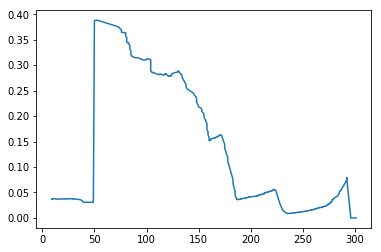

In [90]:
plt.plot(comm, mods)

In [85]:
g._communities

[203,
 203,
 205,
 205,
 205,
 206,
 206,
 207,
 207,
 207,
 207,
 208,
 208,
 208,
 208,
 209,
 209,
 209,
 210,
 210,
 211,
 212,
 212,
 213,
 213,
 213,
 213,
 213,
 213,
 213,
 214,
 214,
 214,
 215,
 216,
 216,
 217,
 217,
 218,
 218,
 219,
 219,
 220,
 220,
 221,
 221,
 221,
 221,
 222,
 222,
 222,
 222,
 224,
 226,
 228,
 231,
 235,
 235,
 236,
 236,
 237,
 237,
 237,
 238,
 238,
 239,
 239,
 239,
 240,
 240,
 241,
 241,
 241,
 241,
 241,
 241,
 242,
 242,
 242,
 243,
 243,
 243,
 244,
 244,
 244,
 244,
 245,
 245,
 245,
 246,
 246,
 248,
 248,
 248,
 248,
 248,
 249,
 249,
 249,
 250,
 250,
 251,
 251,
 252,
 252,
 252,
 252,
 253,
 253,
 254,
 254,
 254,
 255,
 255,
 256,
 256,
 257,
 257,
 258,
 258,
 259,
 259,
 259,
 259,
 260,
 261,
 261,
 261,
 262,
 262,
 262,
 262,
 263,
 264,
 264,
 265,
 265,
 265,
 266,
 268,
 268,
 269,
 269,
 270,
 271,
 271,
 272,
 273,
 273,
 273,
 274,
 274,
 274,
 275,
 275,
 276,
 276,
 277,
 277,
 277,
 278,
 278,
 278,
 278,
 279,
 279,
 280

In [86]:
g._mods

[0.041892228929440736,
 0.042102115665290575,
 0.042314115232553275,
 0.04252825968171583,
 0.04274458171450679,
 0.04296311470051093,
 0.04318389269430284,
 0.043406950453097906,
 0.043632323454960945,
 0.043860047917585375,
 0.044090160817654864,
 0.044322699910820565,
 0.044557703752307706,
 0.0447952117181889,
 0.04503526402733327,
 0.04527790176405547,
 0.04552316690151788,
 0.045771102325881295,
 0.04602175186124755,
 0.04627516029543037,
 0.046531373406576045,
 0.04679043799067007,
 0.04705240188996758,
 0.04731731402238357,
 0.047585224411864704,
 0.04785618421982049,
 0.0481302457776083,
 0.04840746262014994,
 0.04868788952070568,
 0.04897158252687071,
 0.04925859899782227,
 0.04954899764288599,
 0.049842838561467206,
 0.05014018328441316,
 0.0504410948168517,
 0.05074563768258023,
 0.05105387797006647,
 0.051365883380129596,
 0.05168172327538105,
 0.05200146873147966,
 0.052325192590309565,
 0.05265296951513672,
 0.05298487604785683,
 0.05332099066840272,
 0.05366139385642358

In [343]:
__edges = np.array([
    [0, 1],
    [0, 4], 
    [1, 2],
    [1, 4],
    [4, 3],
    [2, 3],
    [3, 5]
])
np.unique(__edges)
dummy_g = Community(__edges)
print(dummy_g)
dummy_g.find_edge_betweenness(True)

IGRAPH UN-- 6 7 --
+ attr: name (v)
+ edges (vertex names):
0--1, 0--4, 1--2, 1--4, 3--4, 2--3, 3--5



defaultdict(<function __main__.Community.find_edge_betweenness.<locals>.<lambda>()>,
            {(0, 1): 2.0,
             (1, 2): 3.5,
             (0, 4): 3.0,
             (3, 4): 5.5,
             (3, 5): 5.0,
             (1, 4): 2.5,
             (2, 3): 3.5})